In [3]:
from ingestion.kivadataloader import KivaDataLoader
import pandas as pd

m = KivaDataLoader()
cleaneduploans = m.get_clean_dataframe()

print (cleaneduploans.count())

Connected to kivateam.cnd5idfvxmld.us-east-1.rds.amazonaws.com:5432/kiva
The process takes about 5 minutes to run.
loan_id                                        1170548
loan_name                                      1167176
language_english                               1170548
description_length                             1170522
funded_amount                                  1170548
loan_amount                                    1170548
status_loans                                   1170548
loan_image_provided                            1170548
loan_video_provided                            1170548
activity_name                                  1170548
loan_use_length                                1170532
country_code                                   1170548
country_name                                   1170548
currency_policy                                1170548
currency_exchange_coverage_rate                 906683
currency                                       1170548
curre

In [4]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from config import dbconfig


engine = create_engine(dbconfig.aws_connection_string)
table_names = engine.table_names()
print(table_names)

OperationalError: (psycopg2.OperationalError) could not connect to server: Connection refused
	Is the server running on host "localhost" (::1) and accepting
	TCP/IP connections on port 5432?
could not connect to server: Connection refused
	Is the server running on host "localhost" (127.0.0.1) and accepting
	TCP/IP connections on port 5432?
 (Background on this error at: http://sqlalche.me/e/e3q8)

In [2]:
statement = """SELECT 
loans.loan_id
,loan_name
,CASE WHEN original_language = 'English'  THEN  1 ELSE 0 END AS language_english 
,char_length(description) as description_length
,funded_amount
,loan_amount
,loans.status as status_loans
,CASE WHEN image_id IS NULL THEN  0 ELSE 1 END as loan_image_provided
,CASE WHEN video_id IS NULL THEN  0 ELSE 1 END  as loan_video_provided
,activity_name
,sector_name
,char_length(loan_use) loan_use_length
,country_code
,country_name
,currency_policy
,currency_exchange_coverage_rate
,currency
,CASE WHEN currency = 'USD' THEN 1 ELSE 0 END as currency_usd
,partner_id
,planned_expiration_time
,num_journal_entries
,num_bulk_entries
,CASE WHEN char_length(tags) > 0 THEN  1 ELSE 0 END tags_exist
,borrower_genders
,CASE WHEN borrower_pictured = 'FALSE' THEN 0 ELSE 1 END as atleast1_borrower_pictured
,repayment_interval
,distribution_model
,posted_time_actual
,disburse_to_posted_days
,posted_to_raised_days
,case when posted_to_raised_days < 8 then 0 when posted_to_raised_days < 15 then 1 
when posted_to_raised_days < 22 then 2 else 3 end as posted_to_raised_bins
,disbursed_to_raised_days
,partners.status as partner_status
,rating as partner_rating
,start_date as parner_start_date
,delinquency_rate as partner_delinquency_rate
,default_rate as partner_default_rate
,total_amount_raised as partner_total_amount_raised
,loans_posted as partner_loans_posted
,case when charges_fees_and_interest = 'TRUE' THEN 1 ELSE 0 END as partner_charges_fees_and_interest
,average_loan_size_percent_per_capita_income as partner_avg_loan_size_pct_per_capita_income
,loans_at_risk_rate as partner_loans_at_risk_rate
,currency_exchange_loss_rate as partner_loans_at_risk_rate
,CASE WHEN char_length(url) > 0 THEN  1 ELSE 0 END as partner_url_length
,portfolio_yield as partner_portfolio_yield
,profitability  as partner_profitability
 FROM loans
inner join partners on partners.id = loans.partner_id
inner join loan_dates on loans.loan_id = loan_dates.loan_id
where loans.status = 'funded' 
and posted_to_raised_days >= 0 and posted_to_raised_days <= 30
and borrower_genders <> 'None' 
"""

print (statement)
print ('The above statement takes about 5 minutes to run. Column totals will show when finished.')
#and posted_time_actual >= make_date(2016, 6 ,1) and posted_time_actual <= make_date(2017, 5 ,31)
cleanloans = pd.read_sql_query(statement, engine)

print (cleanloans.count())

SELECT 
loans.loan_id
,loan_name
,CASE WHEN original_language = 'English'  THEN  1 ELSE 0 END AS language_english 
,char_length(description) as description_length
,funded_amount
,loan_amount
,loans.status as status_loans
,CASE WHEN image_id IS NULL THEN  0 ELSE 1 END as loan_image_provided
,CASE WHEN video_id IS NULL THEN  0 ELSE 1 END  as loan_video_provided
,activity_name
,sector_name
,char_length(loan_use) loan_use_length
,country_code
,country_name
,currency_policy
,currency_exchange_coverage_rate
,currency
,CASE WHEN currency = 'USD' THEN 1 ELSE 0 END as currency_usd
,partner_id
,planned_expiration_time
,num_journal_entries
,num_bulk_entries
,CASE WHEN char_length(tags) > 0 THEN  1 ELSE 0 END tags_exist
,borrower_genders
,CASE WHEN borrower_pictured = 'FALSE' THEN 0 ELSE 1 END as atleast1_borrower_pictured
,repayment_interval
,distribution_model
,posted_time_actual
,disburse_to_posted_days
,posted_to_raised_days
,case when posted_to_raised_days < 8 then 0 when posted_to_raised_day

# Add the borrowers code

In [3]:
cleanloans['num_borrowers_female'] = cleanloans['borrower_genders'].str.count('female')
cleanloans['num_borrowers_male'] = cleanloans['borrower_genders'].str.count('^male') + cleanloans['borrower_genders'].str.count('\, male')
cleanloans['num_borrowers'] = cleanloans['num_borrowers_female']+cleanloans['num_borrowers_male']

cleanloans['num_borrowers_female_pct'] = (cleanloans['num_borrowers_female']*1.00)/cleanloans['num_borrowers']

# One Hot the categories

In [4]:
import pandas as pd

cleanloans = pd.concat([cleanloans,pd.get_dummies(cleanloans['sector_name'], prefix='sector_name')],axis=1)
cleanloans.drop(['sector_name'],axis=1, inplace=True)

cleanloans = pd.concat([cleanloans,pd.get_dummies(cleanloans['distribution_model'], prefix='distribution_model')],axis=1)
cleanloans.drop(['distribution_model'],axis=1, inplace=True)

cleanloans = pd.concat([cleanloans,pd.get_dummies(cleanloans['repayment_interval'], prefix='repayment_interval')],axis=1)
cleanloans.drop(['repayment_interval'],axis=1, inplace=True)

In [17]:
print (cleanloans.count())

loan_id                                        1170548
loan_name                                      1167176
language_english                               1170548
description_length                             1170522
funded_amount                                  1170548
loan_amount                                    1170548
status_loans                                   1170548
loan_image_provided                            1170548
loan_video_provided                            1170548
activity_name                                  1170548
loan_use_length                                1170532
country_code                                   1170548
country_name                                   1170548
currency_policy                                1170548
currency_exchange_coverage_rate                 906683
currency                                       1170548
currency_usd                                   1170548
partner_id                                     1170548
planned_ex

In [17]:
print (cleanloans.count())

loan_id                                        1170548
loan_name                                      1167176
language_english                               1170548
description_length                             1170522
funded_amount                                  1170548
loan_amount                                    1170548
status_loans                                   1170548
loan_image_provided                            1170548
loan_video_provided                            1170548
activity_name                                  1170548
loan_use_length                                1170532
country_code                                   1170548
country_name                                   1170548
currency_policy                                1170548
currency_exchange_coverage_rate                 906683
currency                                       1170548
currency_usd                                   1170548
partner_id                                     1170548
planned_ex

In [6]:
cleanloans

,loan_id,loan_name,language_english,description_length,funded_amount,loan_amount,status_loans,loan_image_provided,loan_video_provided,activity_name,...,sector_name_Manufacturing,sector_name_Personal Use,sector_name_Retail,sector_name_Services,sector_name_Transportation,sector_name_Wholesale,distribution_model_field_partner,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly
0,1379923,Ambreen,1,1363.0,200.0,200.0,funded,1,0,Embroidery,...,0,0,0,0,0,0,1,0,0,1
1,305717,None,1,564.0,1200.0,1200.0,funded,1,0,Spare Parts,...,0,0,1,0,0,0,1,0,0,1
2,943811,Rosalinda,1,400.0,325.0,325.0,funded,1,0,Pigs,...,0,0,0,0,0,0,1,0,0,1
3,826788,Nooran,1,653.0,300.0,300.0,funded,1,0,Sewing,...,0,0,0,1,0,0,1,0,1,0
4,822895,DAVID,1,567.0,100.0,100.0,funded,1,0,Renewable Energy Products,...,0,0,1,0,0,0,1,0,0,1
5,387647,GENIE,1,667.0,825.0,825.0,funded,1,0,Bookstore,...,0,0,1,0,0,0,1,0,1,0
6,380386,Silueta De Cristal Group,0,590.0,725.0,725.0,funded,1,0,Cobbler,...,0,0,0,1,0,0,1,0,0,1
7,34485,Ahmadjon,1,712.0,1000.0,1000.0,funded,1,0,Food Market,...,0,0,0,0,0,0,1,0,0,1
8,39014,Epifania Francisca Noa Lozano's Group,1,1378.0,575.0,575.0,funded,1,0,Bakery,...,0,0,0,0,0,0,1,0,0,1
9,30090,Pham Thi,0,1291.0,575.0,575.0,funded,1,0,Crafts,...,0,0,0,0,0,0,1,0,0,1


In [12]:
import statsmodels.api as sm

X = cleanloans[cleanloans['num_borrowers_female_pct'] >= 0]['num_borrowers_female_pct']
y = cleanloans[cleanloans['num_borrowers_female_pct'] >= 0]["posted_to_raised_bins"]

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     posted_to_raised_bins   R-squared:                       0.231
Model:                               OLS   Adj. R-squared:                  0.231
Method:                    Least Squares   F-statistic:                 3.510e+05
Date:                   Sat, 03 Nov 2018   Prob (F-statistic):               0.00
Time:                           14:06:29   Log-Likelihood:            -1.7944e+06
No. Observations:                1170548   AIC:                         3.589e+06
Df Residuals:                    1170547   BIC:                         3.589e+06
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
num_borrowers_female_pct     0.6939      0.001    592.480      0.000       0.692       0.696
==============================================================================
Omnibus:                   153448.314   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           224086.712
Skew:                           1.072   Prob(JB):                         0.00
Kurtosis:                       2.972   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(array([2.24187e+05, 1.31000e+02, 4.49000e+02, 3.75000e+02, 1.05000e+03,
        1.66200e+03, 2.08500e+03, 6.61000e+02, 2.37600e+03, 5.14000e+02,
        7.22600e+03, 4.33200e+03, 1.75700e+03, 7.01100e+03, 2.08900e+03,
        7.03800e+03, 9.15100e+03, 5.78700e+03, 4.78900e+03, 8.87878e+05]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

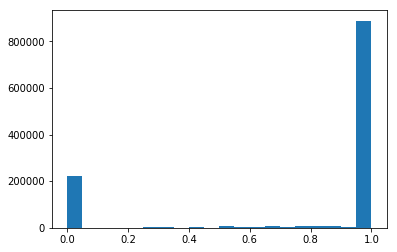

In [8]:
import matplotlib.pyplot as plt

plt.hist(cleanloans['num_borrowers_female_pct'], bins=20)

(array([675050., 243832., 133465., 118201.]),
 array([ 0. ,  7.5, 15. , 22.5, 30. ]),
 <a list of 4 Patch objects>)

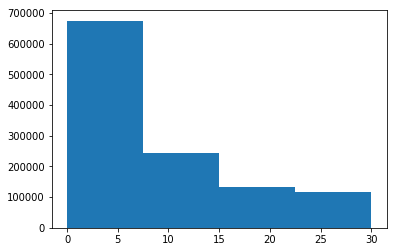

In [9]:
import matplotlib.pyplot as plt

plt.hist(cleanloans['posted_to_raised_days'], bins=4)

In [14]:
import yellowbrick
from yellowbrick.binning import BalancedBinningReference

# Load the a regression data set
data = cleanloans

# Extract the target of interest
y = data["posted_to_raised_days"]

# Instantiate the visualizer
visualizer = BalancedBinningReference()

visualizer.fit(y)          # Fit the data to the visualizer
visualizer.poof()          # Draw/show/poof the data

ModuleNotFoundError: No module named 'yellowbrick.binning'

In [16]:
from yellowbrick.features import ParallelCoordinates

columns = ['a','b']
X = 

visualizer = ParallelCoordinates()
visualizer.fit_transform(X, y)
visualizer.poof()

/anaconda3/lib/python3.6/site-packages/yellowbrick/features/pcoords.py:346: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y = y.as_matrix()


IndexError: tuple index out of range